In [1]:
import pandas as pd
import disaggregator as dis
from disaggregator import data, spatial, plot, config, temporal
import matplotlib.pyplot as plt
import numpy as np

Notice: <br>
The following two fields represent options to turn off warnings in the output (from [Stackoverflow](https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)). This allows the evaluation of the results of the module by the end user without being distracted by red warnings that are not relevant to the evaluation. For development purposes the option to turn those warnings on still remains.

In [2]:
# this part only works when exporting the notebook as a html file
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
# global setting for the whole notebook, can be set to "action = 'once'" if the first warning should be shown
import warnings
warnings.filterwarnings('ignore')

# Area of applications

This notebook demonstrates the functionality of the module to disaggregate the energy consumption over typical areas of application. The chosen applications represent the commonly used separation of final energy usage as in [[BMU](https://www.bmu.de/fileadmin/Daten_BMU/Pools/Forschungsdatenbank/fkz_3712_12_102_energieeffizienzma%C3%9Fnahmen_bewertung_bf.pdf)] or [[AGEB](https://ag-energiebilanzen.de/8-0-Anwendungsbilanzen.html)].

The implementation of this disaggreation is mainly implemented trough a function for the spatial data and another function for the temporal data. This allows to view the level of detail that is wanted in each case.

**nur in ba --> beim einlesen werden ME(strom) bzw. Raumwärme(gas) angepasst da sie die größten anteile darstellen**

def split_on_applications(sector='CTS', source='power'): #**kwargs
    """
    verstellbarkeit/wachstum
    "disaggregate_applications" nennen

    """
    # year = kwargs.get("year", cfg["base_year"])
    
    # reading and preapring the consumption table
    if source == "power":
        eev = pd.read_excel("./test.xlsx", sheet_name = "Endenergieverbrauch Strom Test")
    elif source == "gas":
        eev = pd.read_excel("./test.xlsx", sheet_name = "Endenergieverbrauch Gas Test")
    else:
        print("'source' needs to be 'power' or 'gas'")
        return
    
    eev_clean = eev.loc[[isinstance(x, int) for x in eev["WZ"]]] # nur die WZ
    # use WZ as index for further operations
    eev_clean = eev_clean.set_index("WZ")

    if sector == "CTS":
        ec = spatial.disagg_CTS_industry(source, sector, use_nuts3code = True) # year = year
    elif sector == "industry":
        ec = spatial.disagg_CTS_industry(source, sector, use_nuts3code = True) # year = year
    else:
        print("'sector' must be 'CTS' or 'industry'")
        return
        
    usage = eev_clean.loc[ec.index]

    # for better acces
    ec = ec.T
    
    # creating the multiindex
    multi_wz = [elem for elem in list(ec.columns) for _ in range(len(eev_clean.columns))]
    multi_app = list(usage.columns[:]) * len(usage.index)
    
    tuples = list(zip(*[multi_wz, multi_app]))
    columns = pd.MultiIndex.from_tuples(tuples, names = ["WZ", "VW"])
    
    new_df = pd.DataFrame(columns = columns, index = ec.index)
    
    for wz in new_df.columns.get_level_values(0).unique():
        for app in new_df.columns.get_level_values(1).unique():
            percent = usage.loc[wz, app]
            new_df[wz, app] = ec[wz] * percent
            
    # Plausibility check:
    msg = ('The sum of consumptions (={:.3f}) and the sum of disaggrega'
           'ted consumptions (={:.3f}) do not match! Please check algorithm!')
    total_sum = ec.sum().sum()
    disagg_sum = new_df.sum().sum()
    assert np.isclose(total_sum, disagg_sum), msg.format(total_sum, disagg_sum)
    
    
    return new_df

# disaggregate the spatial data

The relevant function for spatial data is **spatial.disagg_applications()**. This function is based on *spatial.disagg_CTS_industry()* whose functionality gets demonstrated in *03_Demo_CTS_Industry_disaggregation*. 

The function yields a table with the consumption per branch ("WZ") and application ("AWB") for every district in germany.

In [4]:
ec_industry = spatial.disagg_applications(source = "power", sector = "industry", use_nuts3code = True)
ec_industry.head()

WZ             5                                                      \
AWB   Beleuchtung  IKT Klimakälte Prozesskälte Mechanische \nEnergie   
DEF01         0.0  0.0        0.0          0.0                   0.0   
DEF02         0.0  0.0        0.0          0.0                   0.0   
DEF03         0.0  0.0        0.0          0.0                   0.0   
DEF04         0.0  0.0        0.0          0.0                   0.0   
DEF05         0.0  0.0        0.0          0.0                   0.0   

WZ                                                6                ...  \
AWB   Prozesswärme Raumwärme Warmwasser  Beleuchtung          IKT  ...   
DEF01          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF02          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF03          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF04          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF05          0.0       0.0        0.0  2737.665436  2494.317397  ...   

WZ             32                       33                           \
AWB     Raumwärme  Warmwasser  Beleuchtung          IKT  Klimakälte   
DEF01   10.437518    6.958345    68.643652    89.694371   21.050720   
DEF02   23.551322   15.700881   389.771283   509.301144  119.529860   
DEF03  264.751652  176.501101   358.322745   468.208386  109.885642   
DEF04   29.974410   19.982940   153.430750   200.482846   47.052097   
DEF05    7.560510    5.040340  1798.581730  2350.146794  551.565064   

WZ                                                                            
AWB   Prozesskälte Mechanische \nEnergie Prozesswärme   Raumwärme Warmwasser  
DEF01     6.406741            455.793847    69.558900    5.491492   3.660995  
DEF02    36.378653           2588.081321   394.968234   31.181703  20.787802  
DEF03    33.443456           2379.263024   363.100381   28.665820  19.110546  
DEF04    14.320203           1018.780178   155.476493   12.274460   8.182973  
DEF05   167.867628          11942.582686  1822.562820  143.886538  95.924359  

[5 rows x 232 columns]

# der hat noch probleme mit plausibilität, alle andere funktionieren
spatial.disaggregate_applications(source = "gas", sector = "industry")

# spatial graphs

This data can be visualised via the *plot* module. Perhaps the easiest  way to get fast results is to group the data off all branches together and get the consumption per application and district

In [5]:
ec_industry_applications = ec_industry.groupby("AWB", axis = 1).sum()/1000
ec_industry_applications.head()

AWB,Beleuchtung,IKT,Klimakälte,Mechanische \nEnergie,Prozesskälte,Prozesswärme,Raumwärme,Warmwasser
DEF01,4.589563,4.894792,2.489023,69.136599,3.940820,9.667805,0.349218,0.232812
DEF02,12.356891,12.794354,4.789209,113.120029,4.862297,15.387444,0.937118,0.624745
DEF03,12.593906,14.656007,5.963181,145.656661,11.950131,27.162035,0.974467,0.649645
DEF04,6.812981,6.804998,2.767980,83.164448,3.494442,17.256733,0.514712,0.343141
DEF05,25.922834,26.993871,16.421573,603.813295,77.791211,195.410880,1.938415,1.292276


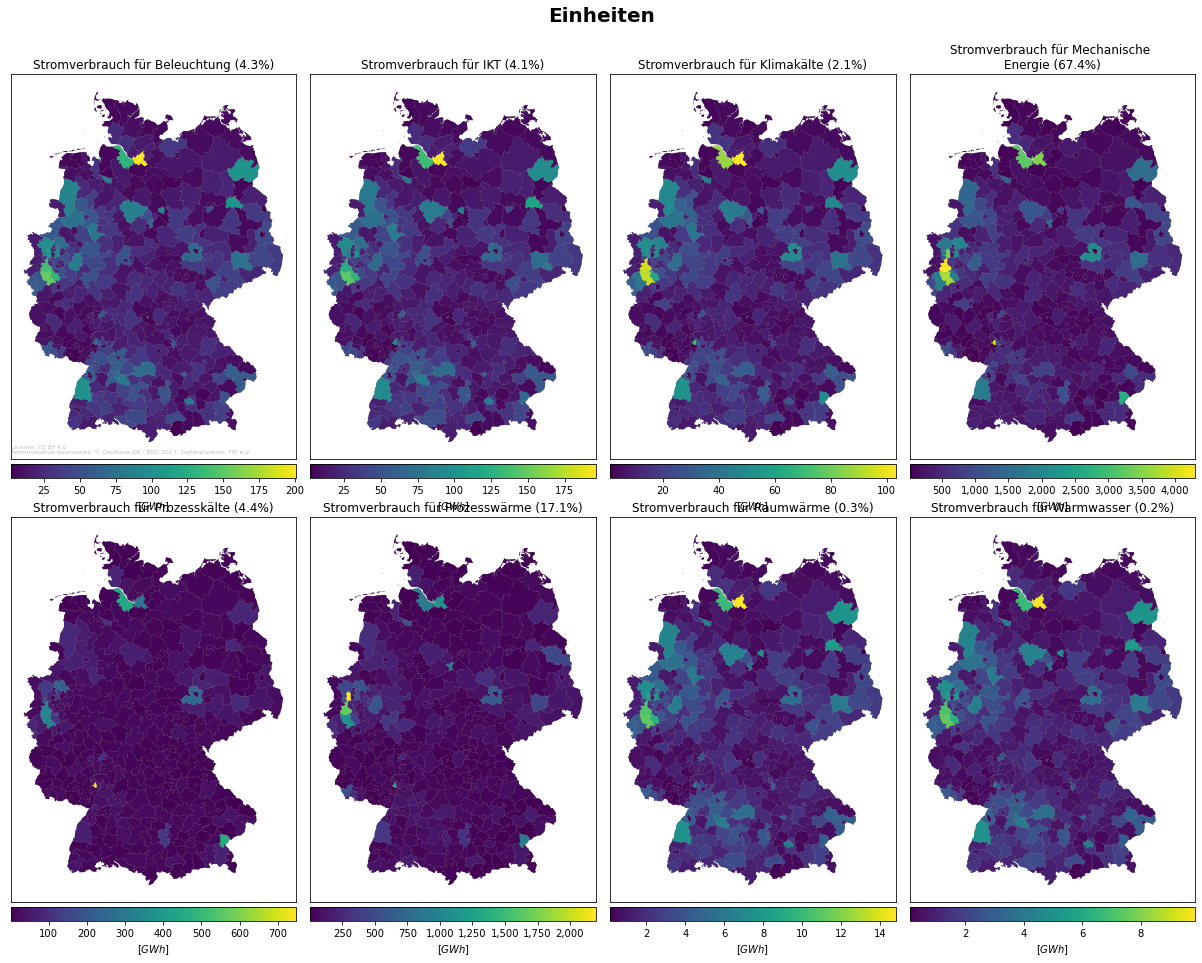

In [6]:
fig, ax = plot.choropleth_map(ec_industry_applications, relative=False, unit='GWh', axtitle='Stromverbrauch für', 
                              colorbar_each_subplot=True,  add_percentages=True, suptitle = "Einheiten")

Another option to visualise the data is to choose a specific branch and get the data for every application.

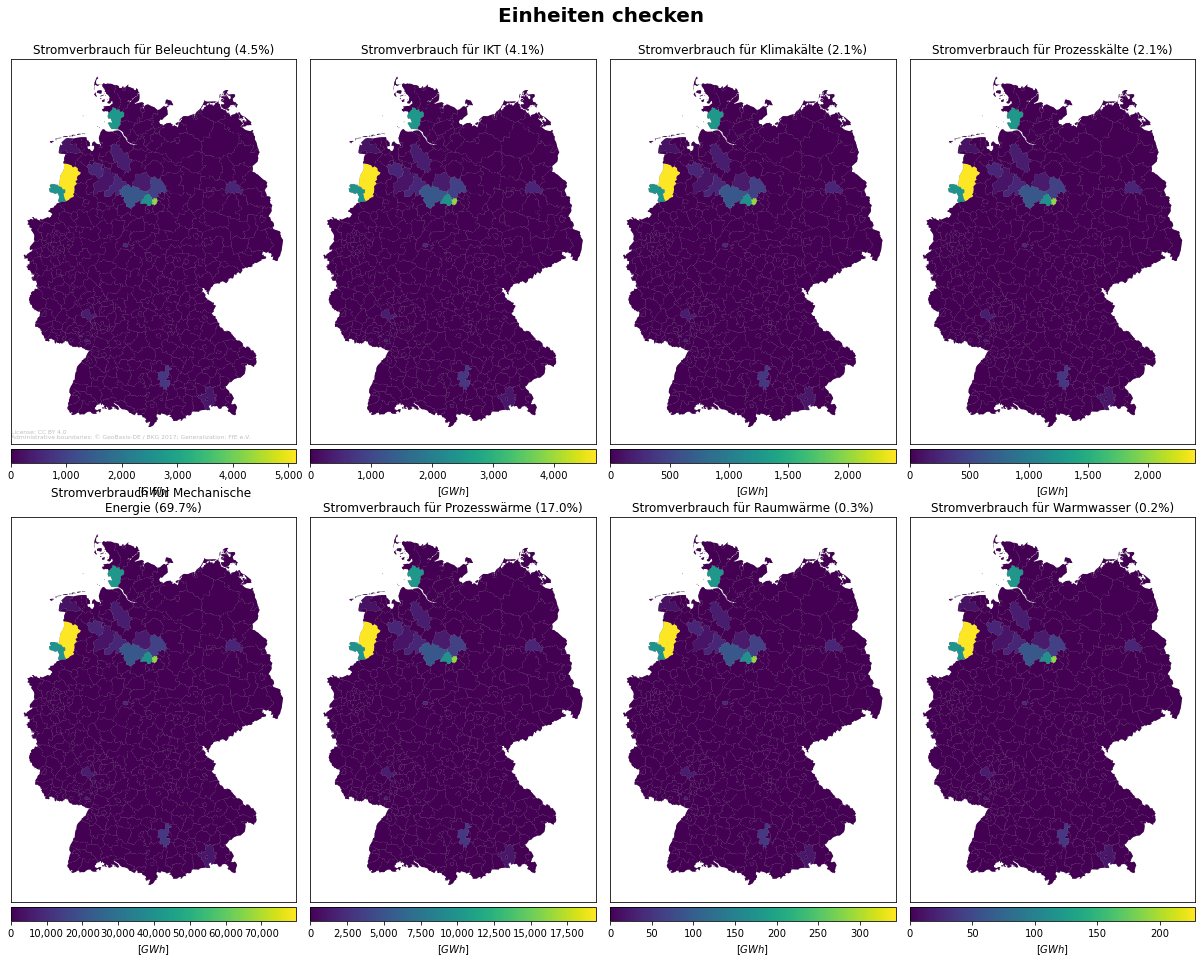

In [7]:
# mal colorbar_each_suplot = False bekommen, damit nicht jeder graph gleich aussieht
fig, ax = plot.choropleth_map(ec_industry[6], relative=False, unit='GWh', axtitle='Stromverbrauch für', suptitle = "Einheiten checken",
                              colorbar_each_subplot=True,  add_percentages=True)

# disaggregate the temporal data

The relevant function for temporal data is **temporal.disagg_temporal_applications()**. 

The function yields a time-indexed table with the consumption per district ("LK") and application ("AWB") in the simple case or the comsumption for ever district ("LK") - branch ("WZ) - application ("AWB") combination

zeitlich muss noch angepasst werden im modul
- funktions beschreibung 
- verstellbarkeit
- plausibilität
- zeitliche folgen in die Funktion? würde das sector benötigt problem lösen
- print den fortschritt beim disagg

def temporal_split_on_applications(df, wz = None, source = "power", sector = "industry"):
    """
    verschiebbarkeit
    plausibility check
    """
    # variable check
    assert source in ["power", "gas"], "'source' needs to be 'power' or 'gas'"
    assert sector in ["CTS", "industry"], "'sector' needs to be 'CTS' or 'industry'"
    assert df.columns.nlevels in [1, 2], "The input df needs to have either the LK as columns or a multiindexed columns with LK and VW"
    
    # reading and preapring the consumption table
    if source == "power":
        eev = pd.read_excel("./test.xlsx", sheet_name = "Endenergieverbrauch Strom Test")
    if source == "gas":
        eev = pd.read_excel("./test.xlsx", sheet_name = "Endenergieverbrauch Gas Test")
    
    eev_clean = eev.loc[[isinstance(x, int) for x in eev["WZ"]]] # nur die WZ
    # use WZ as index for further operations
    eev_clean = eev_clean.set_index("WZ")
    
    # if there are 4 or 8 different applications
    amount_application = len(eev_clean.columns)
    
    # check if WZ are grouped together
    if df.columns.nlevels == 1:
        ### aktuell noch nicht schön
        if source == "power":
            # ec cts hat aktuel 1.01 summe
            if sector == "CTS": percentages = {"Beleuchtung": 0.326, "IKT": 0.151, "Klimakälte": 0.019, "Mechanische \nEnergie": 0.307, "Prozesskälte": 0.077, "Prozesswärme": 0.049, "Raumwärme": 0.037, "Warmwasser": 0.035}
            if sector == "industry": percentages = {"Beleuchtung": 0.043, "IKT": 0.041, "Klimakälte": 0.021, "Mechanische \nEnergie": 0.674, "Prozesskälte": 0.044, "Prozesswärme": 0.172, "Raumwärme": 0.003, "Warmwasser": 0.002}
        if source == "gas":
            if sector == "CTS": percentages = {"Mechanische \nEnergie": 0.045, "Prozesswärme": 0.102, "Raumwärme": 0.805, "Warmwasser": 0.048}
            # gc industry ändert sich evtl durch plausibilität anpassungen
            if sector == "industry": percentages = {"Mechanische \nEnergie": 0.028, "Prozesswärme": 0.693, "Raumwärme": 0.269, "Warmwasser": 0.01}
        
        # creating the multiindex
        multi_lk = [elem for elem in list(df.columns) for _ in range(amount_application)]
        multi_app = list(eev_clean.columns) * len(df.columns)
        tuples = list(zip(*[multi_lk, multi_app]))
        index = pd.MultiIndex.from_tuples(tuples, names = ["LK", "VW"])
        
        # new df with multiindex columns and datetime as index
        new_df = pd.DataFrame(columns = index, index = df.index)
        
        # for every lk multiply the consumption with the percentual use for that application
        for lk in df.columns:
            for app in eev_clean.columns:
                percent = percentages[app]
                new_df[lk, app] = percent * df[lk]
    
    
    # check if evaluating for every WZ
    if df.columns.nlevels == 2:
        # check if WZ was given in a useable format
        if isinstance(wz, int):
            wz = [wz]
        else:
            assert isinstance(wz, list), "'wz' needs to be an integer or a list."
            
        # overwrite eev_clean with only the necesarry wz to save ram
        try:
            eev_clean = eev_clean.loc[wz]
        except:
            raise AssertionError("the specified WZ is/are not in the input dataframe")

        # creating the multiindex
        multi_lk = [elem for elem in list(df.columns.get_level_values(0).unique()) for _ in range(amount_application * len(wz))]
        multi_wz = [elem for elem in wz for _ in range(amount_application)] * 401
        multi_app = list(eev_clean.columns) * 401 * len(wz)
        tuples = list(zip(*[multi_lk, multi_wz, multi_app]))
        columns = pd.MultiIndex.from_tuples(tuples, names = ["LK", "WZ", "VW"])
        
        # new df with multiindex columns and datetime as index
        new_df = pd.DataFrame(columns = columns, index = df.index)
        
        # sort index for faster lookup in value multiplication
        # new_df.sort_index()
        
        
        # for every lk and WZ multiply the consumption with the percentual use for that application
        for lk in new_df.columns.get_level_values(0).unique(): # all districts
            for wz in new_df.columns.get_level_values(1).unique(): # all branches
                for app in new_df.columns.get_level_values(2).unique(): # all applications
                    percent = eev_clean.loc[wz, app]
                    new_df[lk, wz, app] = percent * df[lk, wz]
        
   
    return new_df

At first we need  to create the temporal dataset. At this point the level of detail to view is decided.

Either we choose to create the time series which aggregates all branches ("WZ") per district ("LK) together which is shown below ...

In [8]:
temp_power_CTS = temporal.disagg_temporal_power_CTS(use_nuts3code = True)

disaggregator.temporal: INFO     Working on state: SH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NI.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HB.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NW.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggrega

In [9]:
temp_power_CTS.head()

,DEF01,DEF02,DEF03,DEF04,DEF05,DEF06,DEF07,DEF08,DEF09,DEF0A,...,DEG0D,DEG0E,DEG0F,DEG0G,DEG0H,DEG0I,DEG0J,DEG0K,DEG0L,DEG0M
2015-01-01 00:00:00,3.058863,8.242635,5.938894,2.684819,3.593621,3.616371,5.350945,5.050490,6.512456,2.120619,...,1.807986,1.233237,2.304731,1.914840,1.842706,2.709830,2.019617,2.002604,2.371099,2.144218
2015-01-01 00:15:00,3.214086,8.811882,6.253592,2.850986,3.734686,3.765253,5.643105,5.327129,6.768813,2.224477,...,1.846516,1.261245,2.388444,1.967879,1.906818,2.818213,2.064165,2.044216,2.435521,2.206908
2015-01-01 00:30:00,3.128686,8.548586,6.074598,2.771275,3.629997,3.672947,5.425396,5.131225,6.579644,2.148445,...,1.803485,1.228816,2.331254,1.917839,1.880723,2.753161,2.011606,1.987285,2.382873,2.160449
2015-01-01 00:45:00,3.053702,8.323666,5.915315,2.701583,3.539390,3.592815,5.224167,4.948449,6.415142,2.080607,...,1.768066,1.201346,2.282482,1.874958,1.860167,2.698078,1.967648,1.939245,2.339173,2.121876
2015-01-01 01:00:00,2.997747,8.158905,5.791911,2.648898,3.469788,3.533299,5.053501,4.792451,6.289144,2.025575,...,1.742893,1.180864,2.247626,1.842771,1.849278,2.658482,1.935170,1.902654,2.308911,2.095333


... or we  choose to create the time series which shows the information of every district ("LK) and branch ("WZ") disaggregated.

In [10]:
temp_power_CTS_detailed = temporal.disagg_temporal_power_CTS(detailed = True, use_nuts3code = True)

disaggregator.temporal: INFO     Working on state: SH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NI.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HB.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NW.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggrega

In [11]:
temp_power_CTS_detailed.head()

LK,DEF01,DEF02,DEF03,DEF04,DEF05,DEF06,DEF07,DEF08,DEF09,DEF0A,...,DEG0D,DEG0E,DEG0F,DEG0G,DEG0H,DEG0I,DEG0J,DEG0K,DEG0L,DEG0M
WZ,1,1,1,1,1,1,1,1,1,1,...,94,94,94,94,94,94,94,94,94,94
2015-01-01 00:00:00,0.004969,0.022169,0.034401,0.065361,0.561878,0.249900,0.454471,0.334451,0.758727,0.262974,...,0.018533,0.006608,0.028232,0.011211,0.009410,0.043929,0.021393,0.012355,0.015965,0.013842
2015-01-01 00:15:00,0.004694,0.020943,0.032497,0.061745,0.530792,0.236075,0.429328,0.315948,0.716750,0.248425,...,0.027295,0.009732,0.041581,0.016512,0.013859,0.064700,0.031508,0.018197,0.023513,0.020387
2015-01-01 00:30:00,0.004536,0.020238,0.031403,0.059666,0.512918,0.228125,0.414870,0.305308,0.692613,0.240059,...,0.024792,0.008840,0.037767,0.014997,0.012588,0.058766,0.028618,0.016528,0.021356,0.018517
2015-01-01 00:45:00,0.004419,0.019716,0.030594,0.058129,0.499706,0.222249,0.404184,0.297444,0.674773,0.233876,...,0.022696,0.008092,0.034575,0.013730,0.011524,0.053799,0.026199,0.015131,0.019551,0.016952
2015-01-01 01:00:00,0.004330,0.019318,0.029976,0.056954,0.489603,0.217755,0.396013,0.291431,0.661131,0.229148,...,0.021063,0.007510,0.032088,0.012742,0.010695,0.049928,0.024314,0.014042,0.018145,0.015733


With the time series created we can call the actual function to disaggregate the data over all applications ("AWB").

This works for the aggregated time series:

In [12]:
simple_power_CTS_time = temporal.disagg_temporal_applications(temp_power_CTS, source = "power", sector = "CTS")
simple_power_CTS_time.head()

LK                        DEF01                                    \
VW                  Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.997189  0.461888   0.058118     0.235532   
2015-01-01 00:15:00    1.047792  0.485327   0.061068     0.247485   
2015-01-01 00:30:00    1.019952  0.472432   0.059445     0.240909   
2015-01-01 00:45:00    0.995507  0.461109   0.058020     0.235135   
2015-01-01 01:00:00    0.977266  0.452660   0.056957     0.230827   

LK                                                                           \
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00              0.939071     0.149884  0.113178   0.107060   
2015-01-01 00:15:00              0.986724     0.157490  0.118921   0.112493   
2015-01-01 00:30:00              0.960506     0.153306  0.115761   0.109504   
2015-01-01 00:45:00              0.937487     0.149631  0.112987   0.106880   
2015-01-01 01:00:00              0.920308     0.146890  0.110917   0.104921   

LK                        DEF02            ...     DEG0L             \
VW                  Beleuchtung       IKT  ... Raumwärme Warmwasser   
2015-01-01 00:00:00    2.687099  1.244638  ...  0.087731   0.082988   
2015-01-01 00:15:00    2.872674  1.330594  ...  0.090114   0.085243   
2015-01-01 00:30:00    2.786839  1.290836  ...  0.088166   0.083401   
2015-01-01 00:45:00    2.713515  1.256873  ...  0.086549   0.081871   
2015-01-01 01:00:00    2.659803  1.231995  ...  0.085430   0.080812   

LK                        DEG0M                                    \
VW                  Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.699015  0.323777   0.040740     0.165105   
2015-01-01 00:15:00    0.719452  0.333243   0.041931     0.169932   
2015-01-01 00:30:00    0.704307  0.326228   0.041049     0.166355   
2015-01-01 00:45:00    0.691731  0.320403   0.040316     0.163384   
2015-01-01 01:00:00    0.683079  0.316395   0.039811     0.161341   

LK                                                                           
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser  
2015-01-01 00:00:00              0.658275     0.105067  0.079336   0.075048  
2015-01-01 00:15:00              0.677521     0.108139  0.081656   0.077242  
2015-01-01 00:30:00              0.663258     0.105862  0.079937   0.075616  
2015-01-01 00:45:00              0.651416     0.103972  0.078509   0.074266  
2015-01-01 01:00:00              0.643267     0.102671  0.077527   0.073337  

[5 rows x 3208 columns]

And also for the further disaggregated time series.

But in the case that we want to get the applications ("AWB") for every district ("LK") and branch ("WZ") we need to specify the branch(es) that we want to view. This is done for computational reason because the full data set gets very large.

The branch can be choosen by setting "*wz*" to an int or a list of branches according to the  naming scheme of**WIE HEI?T DER BUMMS?**

In [13]:
power_CTS_time = temporal.disagg_temporal_applications(temp_power_CTS_detailed, source = "power", sector = "CTS", wz = [1, 36])
power_CTS_time.head()

disaggregator.temporal: INFO     Working on LK 1/401.
disaggregator.temporal: INFO     Working on LK 2/401.
disaggregator.temporal: INFO     Working on LK 3/401.
disaggregator.temporal: INFO     Working on LK 4/401.
disaggregator.temporal: INFO     Working on LK 5/401.
disaggregator.temporal: INFO     Working on LK 6/401.
disaggregator.temporal: INFO     Working on LK 7/401.
disaggregator.temporal: INFO     Working on LK 8/401.
disaggregator.temporal: INFO     Working on LK 9/401.
disaggregator.temporal: INFO     Working on LK 10/401.
disaggregator.temporal: INFO     Working on LK 11/401.
disaggregator.temporal: INFO     Working on LK 12/401.
disaggregator.temporal: INFO     Working on LK 13/401.
disaggregator.temporal: INFO     Working on LK 14/401.
disaggregator.temporal: INFO     Working on LK 15/401.
disaggregator.temporal: INFO     Working on LK 16/401.
disaggregator.temporal: INFO     Working on LK 17/401.
disaggregator.temporal: INFO     Working on LK 18/401.
disaggregator.tempo

LK                        DEF01                                    \
WZ                           1                                      
AWB                 Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.000224  0.000204   0.000104     0.000104   
2015-01-01 00:15:00    0.000211  0.000192   0.000099     0.000099   
2015-01-01 00:30:00    0.000204  0.000186   0.000095     0.000095   
2015-01-01 00:45:00    0.000199  0.000181   0.000093     0.000093   
2015-01-01 01:00:00    0.000195  0.000178   0.000091     0.000091   

LK                                                                           \
WZ                                                                            
AWB                 Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00              0.003463     0.000845  0.000015   0.000010   
2015-01-01 00:15:00              0.003272     0.000798  0.000014   0.000009   
2015-01-01 00:30:00              0.003162     0.000771  0.000014   0.000009   
2015-01-01 00:45:00              0.003080     0.000751  0.000013   0.000009   
2015-01-01 01:00:00              0.003018     0.000736  0.000013   0.000009   

LK                                    ...     DEG0M                         \
WZ                           36       ...        1                      36   
AWB                 Beleuchtung  IKT  ... Raumwärme Warmwasser Beleuchtung   
2015-01-01 00:00:00         0.0  0.0  ...  0.000850   0.000566    0.110645   
2015-01-01 00:15:00         0.0  0.0  ...  0.000803   0.000535    0.113093   
2015-01-01 00:30:00         0.0  0.0  ...  0.000776   0.000517    0.113737   
2015-01-01 00:45:00         0.0  0.0  ...  0.000756   0.000504    0.114638   
2015-01-01 01:00:00         0.0  0.0  ...  0.000740   0.000494    0.116055   

LK                                                                           \
WZ                                                                            
AWB                       IKT Klimakälte Prozesskälte Mechanische \nEnergie   
2015-01-01 00:00:00  0.050405   0.006147     0.026125              0.075915   
2015-01-01 00:15:00  0.051520   0.006283     0.026702              0.077594   
2015-01-01 00:30:00  0.051813   0.006319     0.026855              0.078036   
2015-01-01 00:45:00  0.052224   0.006369     0.027067              0.078655   
2015-01-01 01:00:00  0.052870   0.006448     0.027402              0.079627   

LK                                                     
WZ                                                     
AWB                 Prozesswärme Raumwärme Warmwasser  
2015-01-01 00:00:00     0.014753  0.011372   0.011987  
2015-01-01 00:15:00     0.015079  0.011623   0.012252  
2015-01-01 00:30:00     0.015165  0.011690   0.012321  
2015-01-01 00:45:00     0.015285  0.011782   0.012419  
2015-01-01 01:00:00     0.015474  0.011928   0.012573  

[5 rows x 6416 columns]

# temporal graphs
There are multiple ways to visualise the temporal data sets

## 1. selection of a LK-(WZ)-VW combination

### 1.1. plotting via pyplot
The simplest option to plot the might be to simply call the *.plot()* function from a dataframe which uses the pyplot backend of pandas to visualise the data. This can be used to get a first overview of the underlying data.

<AxesSubplot:>

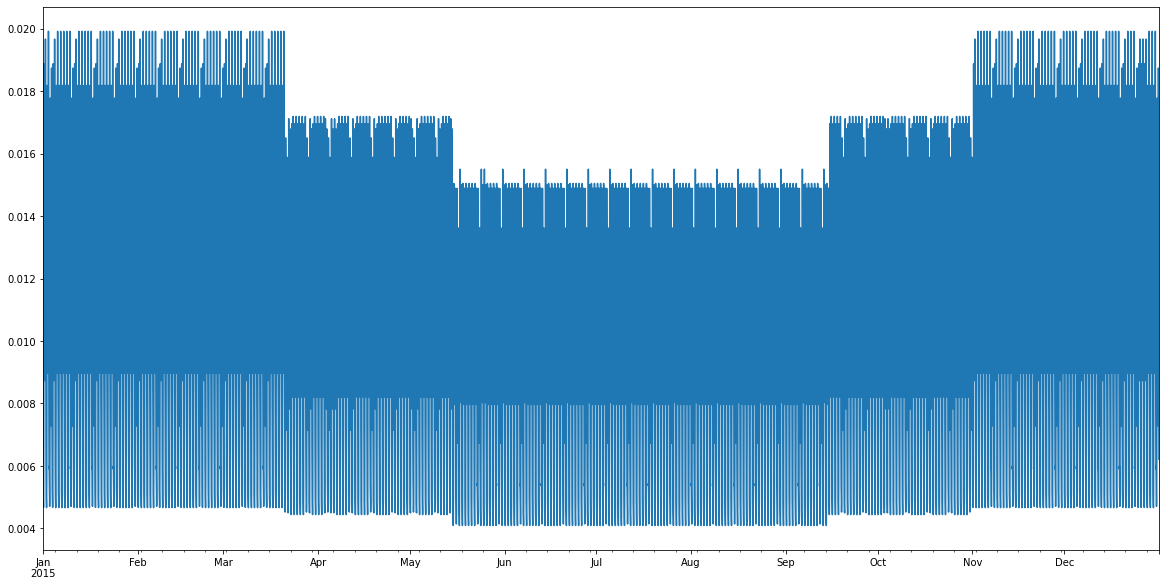

In [14]:
power_CTS_time["DE300", 1, "Beleuchtung"].plot(figsize = (20, 10))

### 1.2. using the heatmap funktion
A more elegant option is to call the *plot.heatmap_timeseries* function to get a heatmap of the same data.

Because the returned data has a resolution of 15 min and the function was the designed the results of simply calling the function might be confusing.

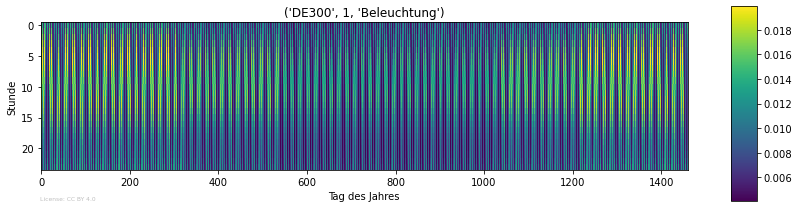

In [15]:
fig, ax = plot.heatmap_timeseries(power_CTS_time["DE300", 1, "Beleuchtung"])

To get a more pleasing visual we resample our data by aggregating the quarter hours into full hours.

In [16]:
power_CTS_hourly = power_CTS_time.resample("h").sum()
power_CTS_hourly.head()

LK                        DEF01                                    \
WZ                           1                                      
AWB                 Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.000838  0.000763   0.000391     0.000391   
2015-01-01 01:00:00    0.000765  0.000697   0.000357     0.000357   
2015-01-01 02:00:00    0.000731  0.000666   0.000341     0.000341   
2015-01-01 03:00:00    0.000704  0.000642   0.000329     0.000329   
2015-01-01 04:00:00    0.000700  0.000637   0.000326     0.000326   

LK                                                                           \
WZ                                                                            
AWB                 Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00              0.012977     0.003165  0.000056   0.000037   
2015-01-01 01:00:00              0.011846     0.002889  0.000051   0.000034   
2015-01-01 02:00:00              0.011329     0.002763  0.000049   0.000033   
2015-01-01 03:00:00              0.010908     0.002660  0.000047   0.000031   
2015-01-01 04:00:00              0.010836     0.002643  0.000047   0.000031   

LK                                    ...     DEG0M                         \
WZ                           36       ...        1                      36   
AWB                 Beleuchtung  IKT  ... Raumwärme Warmwasser Beleuchtung   
2015-01-01 00:00:00         0.0  0.0  ...  0.003184   0.002122    0.452113   
2015-01-01 01:00:00         0.0  0.0  ...  0.002906   0.001938    0.472336   
2015-01-01 02:00:00         0.0  0.0  ...  0.002779   0.001853    0.461903   
2015-01-01 03:00:00         0.0  0.0  ...  0.002676   0.001784    0.433694   
2015-01-01 04:00:00         0.0  0.0  ...  0.002658   0.001772    0.420298   

LK                                                                           \
WZ                                                                            
AWB                       IKT Klimakälte Prozesskälte Mechanische \nEnergie   
2015-01-01 00:00:00  0.205963   0.025117     0.106749              0.310200   
2015-01-01 01:00:00  0.215175   0.026241     0.111524              0.324075   
2015-01-01 02:00:00  0.210422   0.025661     0.109060              0.316917   
2015-01-01 03:00:00  0.197572   0.024094     0.102400              0.297562   
2015-01-01 04:00:00  0.191469   0.023350     0.099237              0.288371   

LK                                                     
WZ                                                     
AWB                 Prozesswärme Raumwärme Warmwasser  
2015-01-01 00:00:00     0.060282  0.046467   0.048979  
2015-01-01 01:00:00     0.062978  0.048546   0.051170  
2015-01-01 02:00:00     0.061587  0.047473   0.050039  
2015-01-01 03:00:00     0.057826  0.044574   0.046984  
2015-01-01 04:00:00     0.056040  0.043197   0.045532  

[5 rows x 6416 columns]

And then call the function again on the resampled data:

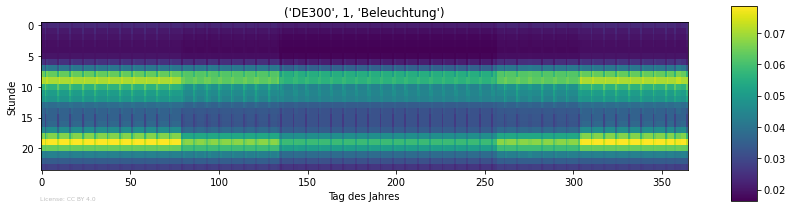

In [17]:
fig, ax = plot.heatmap_timeseries(power_CTS_hourly["DE300", 1, "Beleuchtung"])

## 2. selection of a LK (-WZ combination)

### 2.1. via pyplot
To get a line graph of all applications within a district (and branch) 

# muss noch ins plot modul

In [54]:
def temporal_plot_function(df):
    fig, ax = plt.subplots(figsize=(20, 4))
    # the separate WZ
    if df.columns.nlevels == 2:
        grouped_df = df.groupby("WZ", axis = 1).sum()
        for WZ in grouped_df:
            grouped_df[WZ].plot(ax = ax, label = ("WZ " + str(WZ)))
    # whole consumption
    elif df.columns.nlevels == 1:
        df.sum(axis = 1).plot(ax = ax, label = "Gesamt")
    else:
        raise ValueError("unexpected Input")
    for col in df:
        df[col].plot(ax = ax, label = col)
    plt.legend(loc = "upper left", bbox_to_anchor=(1.02, 0.9))
    return fig, ax

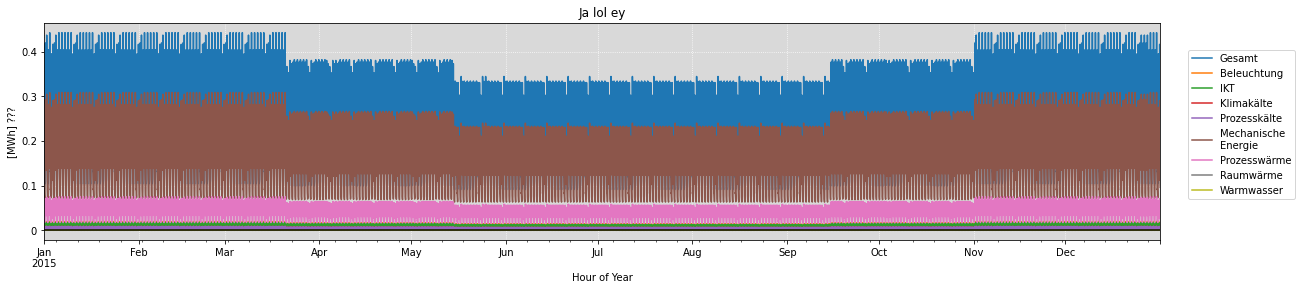

In [57]:
fig, ax = temporal_plot_function(power_CTS_time["DE300", 1])
plot.set_ax_format(ax=ax, ylabel='[MWh] ???', xlabel='Hour of Year',
                   axtitle='Ja lol ey')

### 2.2. using the heatmap function

When we call the *plot.heatmap_timeseries* function on a dataframe with a district-branch combination we get the heatmaps for all applications with the same scale:

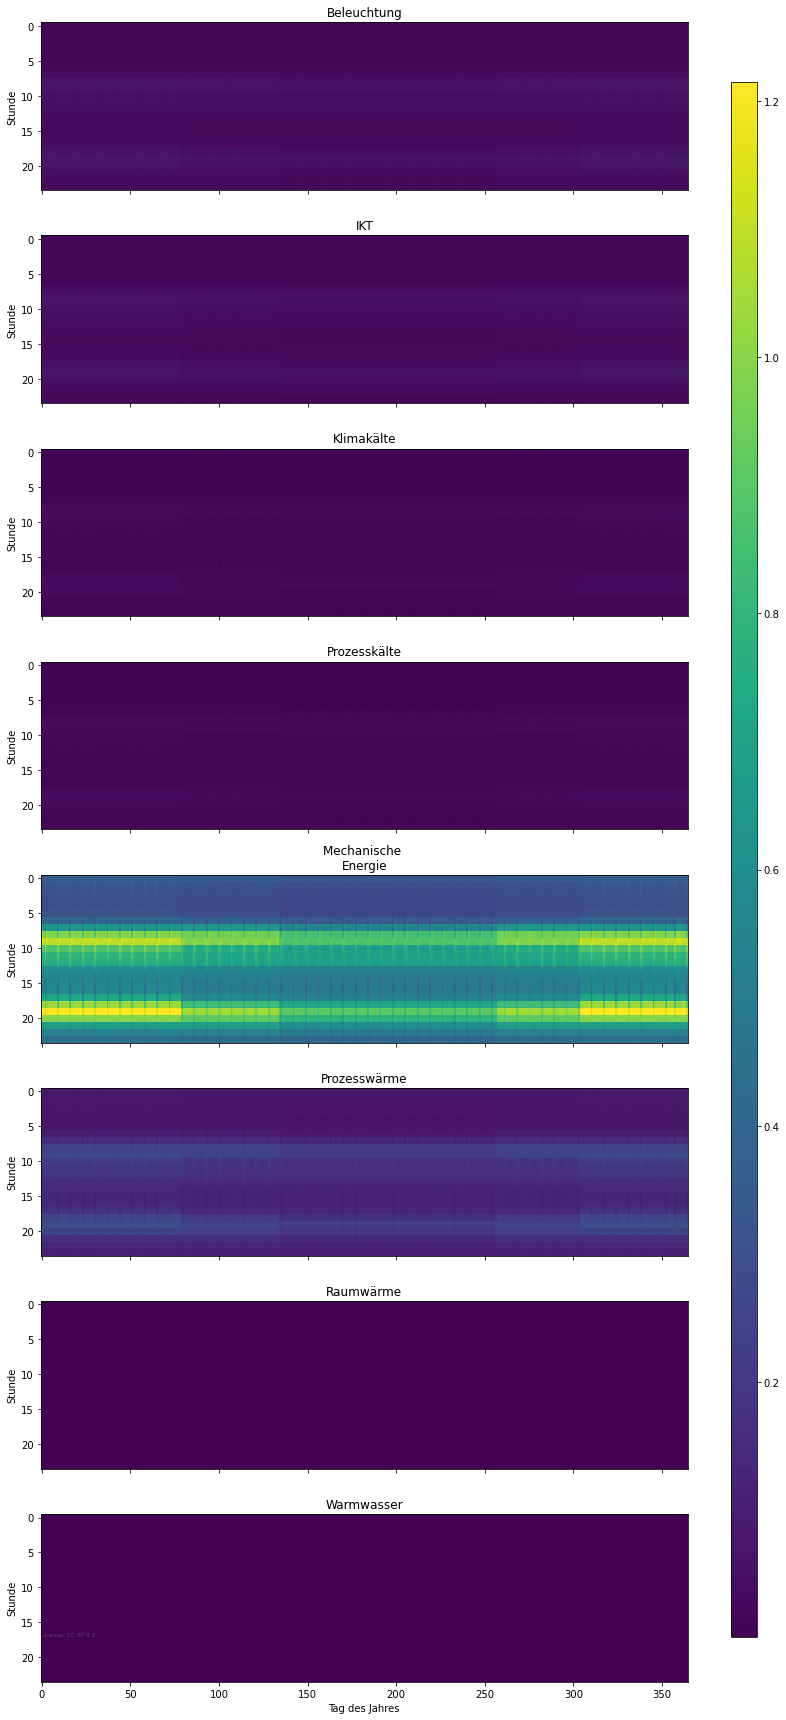

In [19]:
fig, ax = plot.heatmap_timeseries(power_CTS_hourly["DE300", 1])